# Plot for Summary Report: Regression Analysis

In [18]:
%run 'helpers-for-report-plot-generation.ipynb'

In [19]:
def get_data():
    """Get raw data from local database"""
    milk = get_dataset('milk_volume')
    birthdates = get_dataset('birthdates')
    genetics = get_dataset('genetics')
    classification = get_dataset('classification')
        
    return select_milk_features(milk), \
           select_birthdate_features(birthdates), \
           select_genetics_features(genetics), \
           select_classification_features(classification)
    
def select_milk_features(milk):
    """Prepare and select milk features"""
    
    milk = milk.rename(columns={'date':'milk_date'})
    milk = milk.dropna(axis=0, how='any')
    milk = milk.sort_values(['milk_date', 'animal_id']).reset_index()
    
    features = ['animal_id', 'milk_date', 'milk_weight', 'days_since_calving']
    return milk[features]

def select_birthdate_features(birthdates):
    """Prepare and select birthdate features"""
    
    birthdates = birthdates.sort_values(['birthdate']).reset_index()
    
    features = ['animal_id', 'birthdate']
    return birthdates[features]

def select_genetics_features(genetics):
    """Prepare and select genetics features"""
    genetics = genetics.rename(columns={'milk':'milk_score'})
    
    features = ['animal_id', 'milk_score', 'ctpi']
    return genetics[features]

def select_classification_features(classifications):
    """Prepare and select genetics features"""
    
    classifications = classifications.sort_values(['animal_id', 'date'])
    classifications = classifications.drop_duplicates(subset=['animal_id'], keep='last').reset_index()
    
    features = ['animal_id', 'dairy_form', 'udder_score_aggregate', 'dairy_strength_aggregate', \
                'final_score', 'breed_age_average']
    return classifications[features]

In [20]:
def build_annual_performance_profiles(milk, birthdates):
    """Takes milk data and and calculates the performance profiles of each animal by calendar year."""
    years = milk['milk_date'].dt.year.unique()
    profiles = []
    
    for year in years:
        year_mask = (milk['milk_date'].dt.year == year)
        milk_for_year = milk[year_mask]
        
        for animal_id in milk['animal_id'].unique():    
            animal_milk_for_year = milk_for_year[milk_for_year['animal_id'] == animal_id]
            
            profile = {}
            profile['animal_id'] = animal_id
            profile['year'] = year
            
            profile['days_milked'] = animal_milk_for_year.count()['animal_id']
            if profile['days_milked'] == 0:
                profile['days_milked'] = np.NaN
            
            profile['total_milkweight'] = animal_milk_for_year['milk_weight'].sum()
            if profile['total_milkweight'] == 0:
                 profile['total_milkweight'] = np.NaN
            
            profile['milkweight_per_day'] = animal_milk_for_year['milk_weight'].mean()
            if profile['total_milkweight'] == 0:
                profile['total_milkweight'] = np.NaN
            
            profiles.append(profile)
         
    data = pd.DataFrame(profiles)
    data.describe()
    data = data.sort_values(['year', 'animal_id', 'milkweight_per_day']).reset_index()
    features = ['year', 'animal_id', 'days_milked', 'milkweight_per_day', 'total_milkweight']
    return data[features]

In [21]:
def append_previous_year_profiles_to_milk_data(milk, profiles):
    """For each milk_date, animal_id combination, retrieve the profile from the previous year and merge to dataframe"""
    
    milk['prior_year'] = milk['milk_date'].dt.year - 1
    milk = milk.set_index(['milk_date'])['2016-01-01':'2017-12-31'].reset_index()
    
    data = pd.merge(left=milk, right=profiles, left_on=['prior_year', 'animal_id'], right_on=['year', 'animal_id'])
    features = ['milk_date', 'animal_id', 'milk_weight', 'days_since_calving', 'milkweight_per_day']
    
    return data[features].rename(columns={'milkweight_per_day':'prior_year_milkweight_per_day'})

In [22]:
def append_months_aged_to_milk_data(milk, birthdates):
    """Calcualte the number of months aged for on each milking date"""
    data = pd.merge(left=milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    data['age_in_months'] = (data['milk_date'] - data['birthdate']).astype('timedelta64[M]')
    
    features = ['milk_date', 'animal_id', 'milk_weight', 'age_in_months', \
                'prior_year_milkweight_per_day', 'days_since_calving']
    return data[features]

In [23]:
def aggregate_data_for_regression(milk, genetics, classification):
    """Merge Genetics, Milk, and Classification Data Sets"""
    data = pd.merge(left=milk, right=genetics, left_on='animal_id', right_on='animal_id')
    data = pd.merge(left=data, right=classification, left_on='animal_id', right_on='animal_id')    
    return data

In [24]:
def get_data_for_analysis():
    milk, birthdates, genetics, classification = get_data()
    profiles = build_annual_performance_profiles(milk, birthdates)
    milk = append_previous_year_profiles_to_milk_data(milk, profiles)
    milk = append_months_aged_to_milk_data(milk, birthdates)
    return aggregate_data_for_regression(milk, genetics, classification)

data = get_data_for_analysis()
data = data.dropna(axis=0, how='any')
data = data[data['days_since_calving'] < 305]
data.sample(10)

,milk_date,animal_id,milk_weight,age_in_months,prior_year_milkweight_per_day,days_since_calving,milk_score,ctpi,dairy_form,udder_score_aggregate,dairy_strength_aggregate,final_score,breed_age_average
3481,2016-02-06,1807,96.1,63.0,78.019512,79.0,-407,1488,22.0,82.0,82.0,81.0,101.599998
7607,2017-07-29,1854,75.8,74.0,77.346259,84.0,-60,1734,35.0,82.0,87.0,85.0,107.599998
22334,2017-03-24,1988,43.0,52.0,66.506316,146.0,-146,1567,31.0,87.0,86.0,87.0,108.900002
16701,2016-10-29,1954,97.0,52.0,72.822059,3.0,456,2004,36.0,83.0,89.0,85.0,106.000000
24027,2016-09-24,1999,83.1,45.0,104.776667,298.0,1772,2198,42.0,87.0,92.0,88.0,110.000000
29319,2016-01-03,2027,39.9,32.0,77.007263,207.0,1198,2104,35.0,85.0,86.0,85.0,109.699997
59117,2016-11-01,1906,45.4,60.0,97.211712,234.0,76,1510,37.0,87.0,88.0,86.0,107.199997
61681,2017-09-25,1814,28.9,81.0,65.063082,199.0,-524,1291,33.0,78.0,85.0,80.0,100.199997
12585,2016-01-20,1908,84.5,50.0,34.700000,27.0,138,1626,35.0,81.0,88.0,82.0,102.199997
49531,2017-03-11,2092,105.3,38.0,63.723794,49.0,584,1969,28.0,80.0,81.0,79.0,102.400002


In [14]:
y = data['milk_weight']
X = data.drop(axis=1, labels=['milk_weight'])

In [26]:
def plot_model_scatter_plot(y_test, y_pred):

    plt.scatter(y_test, y_pred)
    plt.plot([0,350],[0,350])
    plt.xlabel('One-Day Milk Weight Actual')
    plt.ylabel('One-Day Milk Weight Predicted')
    save_plot_for_summary_report('regression-predicted-versus-actual.png')
    plt.show()
    
    residuals = (np.subtract(y_test, y_pred)) 
    normed_residuals = residuals / y_test.std()

    sns.residplot(y=normed_residuals, x=y_test)
    plt.ylabel('Residual Error')
    plt.xlabel('Fitted Values')
    save_plot_for_summary_report('regression-residual-errors.png')
    plt.show()

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Best Paremeters: {'forest__max_features': 'auto', 'forest__n_estimators': 14}
CV_Score: 0.27231984874088677


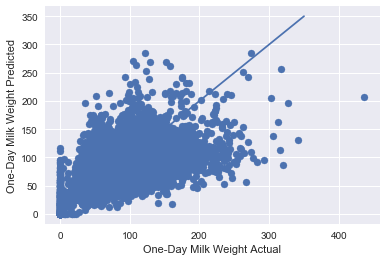

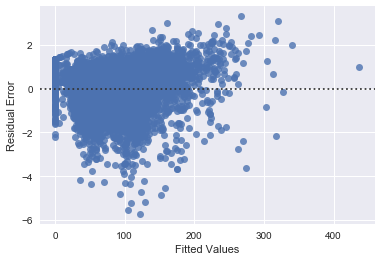

In [27]:
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='median', axis=0)), 
         ('scalar', StandardScaler()),
         ('forest', RandomForestRegressor())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'forest__n_estimators':np.arange(2, 15, 2),
              'forest__max_features':['auto', 'sqrt', 'log2']}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
m_cv = GridSearchCV(pipeline, cv=3, param_grid=parameters)

# Fit to the training set
m_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = m_cv.score(X_test, y_test)
print("Best Paremeters: {}".format(m_cv.best_params_))
print("CV_Score: {}".format(r2))

y_pred = m_cv.predict(X_test)
plot_model_scatter_plot(y_test, y_pred)